# Outline
1. EDA
2. Deal with missing value
3. Feature engineering
4. Preprocessing
5. Model training
6. Evaluation
7. Prediction

# Libraries

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import auc, f1_score

# Helper functions

In [22]:
# show the missing value percentage for features
def missing_value_percentage(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percentage = (df.isnull().sum() / len(df)).sort_values(ascending=False) * 100
    percentage_str = percentage.map('{:.2f}%'.format)
    missing_data = pd.concat([total, percentage_str], axis=1, keys=['Total', 'Percentage'])
    missing_data = missing_data[total > 0]

    return missing_data

In [23]:
def random_select(df, target, features):
    selection = df[target].sample(n=1).iloc[0]
    df_selected = df[df[target] == selection][[target] + features]
    return df_selected

| Feature Name                  | Description                                |
|-------------------------------|--------------------------------------------|
| `person_age`                  | Age                                        |
| `person_income`               | Annual Income                              |
| `person_home_ownership`       | Home ownership                             |
| `person_emp_length`           | Employment length (in years)               |
| `loan_intent`                 | Loan intent                                |
| `loan_grade`                  | Loan grade                                 |
| `loan_amnt`                   | Loan amount                                |
| `loan_int_rate`               | Interest rate                              |
| `loan_status`                 | Loan status (0 is non default 1 is default)|
| `loan_percent_income`         | Percent income                             |
| `cb_person_default_on_file`   | Historical default                         |
| `cb_preson_cred_hist_length`  | Credit history length                      |


In [24]:
data = pd.read_csv("credit_risk_dataset.csv")

# EDA

In [25]:
data

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


In [26]:
data.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [27]:
features = data.columns.drop(["loan_status"])

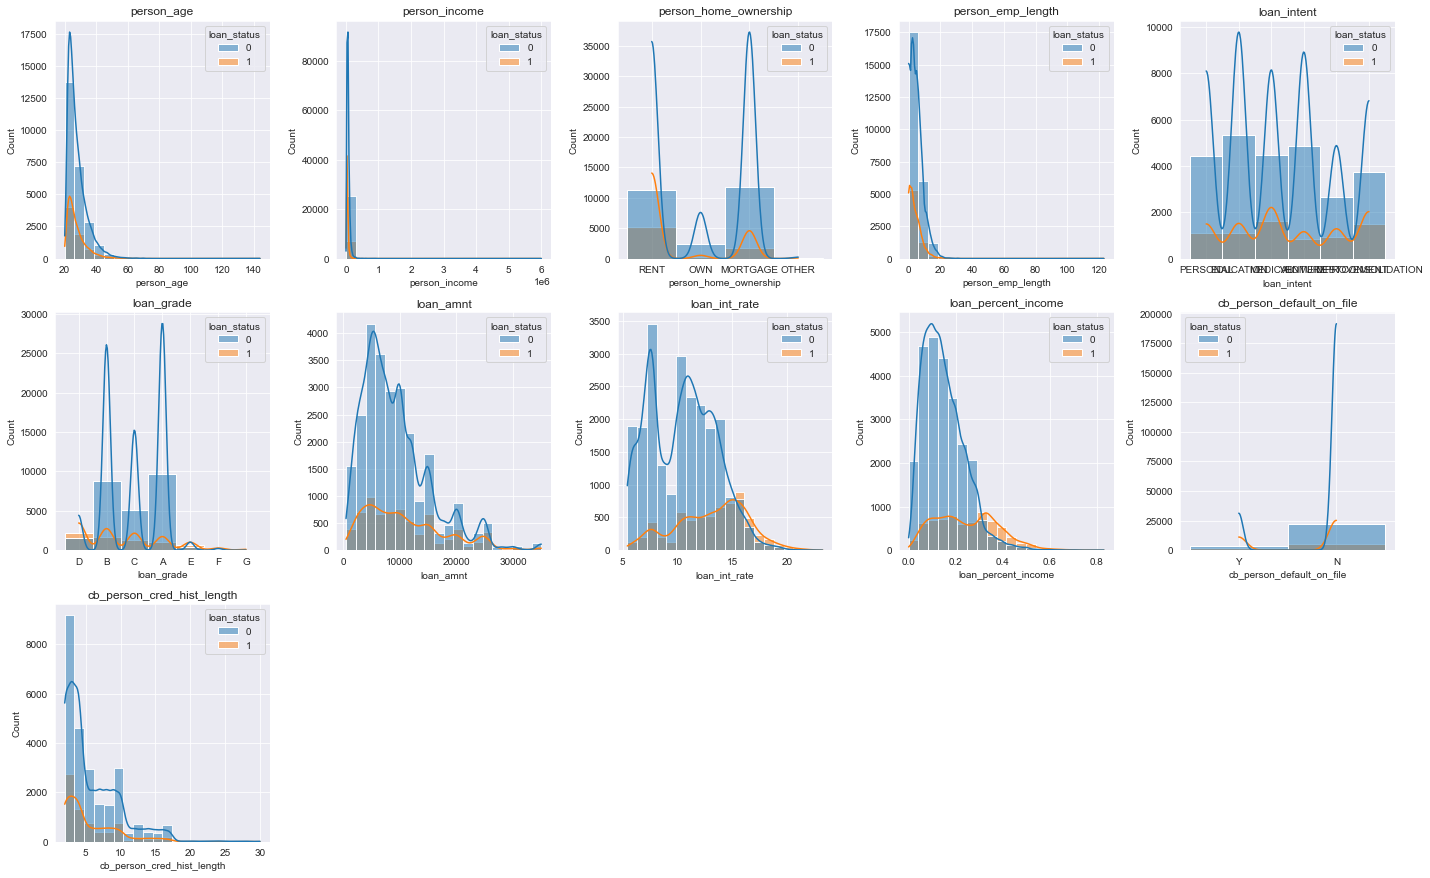

In [28]:
features = data.columns.drop(["loan_status"])
feature_data = data[features]

fig = plt.figure(figsize=(20, 20))

for idx, val in enumerate(features):
    ax = fig.add_subplot(5, 5, idx + 1)
    sns.histplot(data=data, x=val, axes=ax, bins=20, hue='loan_status', kde=True)
    ax.set_title(val)

plt.tight_layout()
plt.show()

<AxesSubplot:>

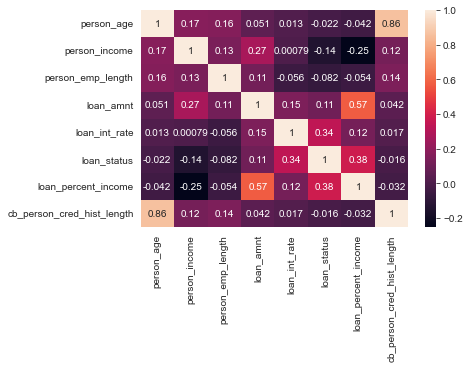

In [29]:
numerical_features = [col for col in data.columns if data[col].dtype in ["float64", "int64"]]
corr_matrix = data[numerical_features].corr()
sns.heatmap(corr_matrix, annot=True)

# Dealing with missing values

In [30]:
missing_value_percentage(data)

,Total,Percentage
loan_int_rate,3116,9.56%
person_emp_length,895,2.75%


- No high relation columns with loand_int_rate and person_emp_length, so we would use other columns to impute missing values.
- Instead, using mean/median/mode to impute

In [31]:
def imputation(df, column, strategy):
    df_copy = df.copy()
    imputer = SimpleImputer(missing_values=np.nan, strategy=strategy)

    df_copy[[column]] = imputer.fit_transform(df_copy[[column]])

    return df_copy

In [32]:
data = imputation(data, 'loan_int_rate', 'median')
data = imputation(data, 'person_emp_length', 'median')

In [33]:
missing_value_percentage(data)

,Total,Percentage


# Preprocessing

(scaling, normalization, skewness, imbalance)

## Scaling

In [34]:
def scaling(df, numerical_features):
    scaler = StandardScaler()
    df[numerical_features] = scaler.fit_transform(df[numerical_features])

    return df

In [35]:
numerical_features

In [36]:
data = scaling(data, numerical_features)

In [37]:
data.describe()

# Encoding

In [38]:
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [39]:
data.groupby(["person_home_ownership"]).size()

person_home_ownership
MORTGAGE    13444
OTHER         107
OWN          2584
RENT        16446
dtype: int64

In [40]:
data["person_home_ownership"] = np.where(
    data["person_home_ownership"] == "OWN", 0, np.where(
        data["person_home_ownership"] == "RENT", 1, np.where(
            data["person_home_ownership"] == "MORTGAGE",2, 3
        )
    )
)

In [41]:
def encoding(df):
    categorical_features = [col for col in df.columns if df[col].dtype == "object"]

    high_cardinality = [col for col in categorical_features if df[col].nunique() > 2]
    low_cardinality = [col for col in categorical_features if col not in high_cardinality]

    df_dummies = pd.DataFrame()
    for col in high_cardinality:
        dummies = pd.get_dummies(df[col])

        df_dummies = pd.concat([df_dummies, dummies], axis=1)

    df = df.drop(high_cardinality, axis=1)
    df_new = pd.concat([df, df_dummies], axis=1)

    encoder = OrdinalEncoder()

    df_new[low_cardinality] = encoder.fit_transform(df_new[low_cardinality])

    return df_new

In [42]:
data_encoded = encoding(data)
data_encoded

,person_age,person_income,person_home_ownership,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,...,MEDICAL,PERSONAL,VENTURE,A,B,C,D,E,F,G
0,22,59000,1,123.0,35000,16.02,1,0.59,1.0,3,...,0,1,0,0,0,0,1,0,0,0
1,21,9600,0,5.0,1000,11.14,0,0.10,0.0,2,...,0,0,0,0,1,0,0,0,0,0
2,25,9600,2,1.0,5500,12.87,1,0.57,0.0,3,...,1,0,0,0,0,1,0,0,0,0
3,23,65500,1,4.0,35000,15.23,1,0.53,0.0,2,...,1,0,0,0,0,1,0,0,0,0
4,24,54400,1,8.0,35000,14.27,1,0.55,1.0,4,...,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,2,1.0,5800,13.16,0,0.11,0.0,30,...,0,1,0,0,0,1,0,0,0,0
32577,54,120000,2,4.0,17625,7.49,0,0.15,0.0,19,...,0,1,0,1,0,0,0,0,0,0
32578,65,76000,1,3.0,35000,10.99,1,0.46,0.0,28,...,0,0,0,0,1,0,0,0,0,0
32579,56,150000,2,5.0,15000,11.48,0,0.10,0.0,26,...,0,1,0,0,1,0,0,0,0,0


# Model training

In [68]:
RANDOM_STATE = 40
data_encoded["id"] = data_encoded.index + 1
target = data_encoded[["id", "loan_status"]]
train = data_encoded.drop(["loan_status"], axis=1).copy()

In [69]:
model = IsolationForest(random_state=RANDOM_STATE)

In [ ]:
param_dict = {
    'n_estimators' : [30, 50, 100],
    'max_examples' : [1, 5, 10],
    'contamination' : ['auto', 0.0001, 0.0002],
    'max_features' : [10, 15, 20, 25],
    'bootstrap' : [True],
    'n_jobs' : [-1]
}

In [ ]:
random_search = RandomizedSearchCV(model,
                                   param_dict,
                                   scoring="neg_mean_squared_error",
                                   refit=True,
                                   cv=10,
                                   return_train_score=True)

In [70]:
model.fit(train[["id"]])

D:\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.1, n_estimators=50)

In [71]:
train["scores"] = model.decision_function(train[["id"]])
train['anomaly'] = model.predict(train[["id"]])

In [72]:
df_final = pd.merge(train, target, how="left", on="id")

In [81]:
def evaluation(df):
    df_final["anomaly_transform"] = np.where(df_final['anomaly']==-1, 1, 0)
    nonmatch = df_final[df_final["loan_status"] != df_final["anomaly_transform"]].id.nunique()
    match = df_final[df_final["loan_status"] == df_final["anomaly_transform"]].id.nunique()

    accuracy = match/(match+nonmatch)

    return print(f"accuracy: '{accuracy:.2%}'")

In [82]:
evaluation(df_final)

accuracy: '74.95%'
